In [1]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as ss
import statsmodels.formula.api as smf
import matplotlib.collections as clt
import re
import pylab as pl

from nems_lbhb.pupil_behavior_scripts.mod_per_state import get_model_results_per_state_model
from nems_lbhb.pupil_behavior_scripts.mod_per_state import aud_vs_state
from nems_lbhb.pupil_behavior_scripts.mod_per_state import hlf_analysis
from nems_lbhb.stateplots import model_per_time_wrapper, beta_comp

%matplotlib inline
os.getcwd()

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 60)

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2018-12-31 121852.log
[nems_web INFO] No value specified for: DEBUG. Using default value in nems_web.configs.defaults
[nems_web INFO] No value specified for: CSRF_ENABLED. Using default value in nems_web.configs.defaults
[nems_web INFO] No value specified for: CSRF_SESSION_KEY. Using default value in nems_web.configs.defaults
[nems_web INFO] No value specified for: SECRET_KEY. Using default value in nems_web.configs.defaults
[nems_web INFO] No value specified for: PORT. Using default value in nems_web.configs.defaults


In [2]:
# AC SU+MU 307 DS' data (onBF and offBF together)
# run using beh_only_plot function in mod_per_state.py with state_list = ['st.fil0', 'st.fil'], 
# basemodel = '-ref-psthfr.s_stategain.S'
# loader = 'psth.fs20-ld-'
# fitter = '_jk.nf20-basic'
# get_model_results_per_state_model ---> returning df and saved on /auto/users/daniela/code/python_ACIC_proj/d_fil_307.csv 
# 12/18/18 DS
d_AC_307 = pd.read_csv('d_fil_307.csv')
d_AC_307 = d_AC_307.drop(['Unnamed: 0'], axis=1)
d_AC_307['experimenter'] = 'DS'
d_AC_307['area'] = 'AC'
d_AC_307['onBF'] = 'TBD'
d_AC_307['SU'] = False
d_AC_307.loc[d_AC_307['isolation']>=90.0, 'SU'] = True
d_AC_307['animal'] = d_AC_307['cellid'].map(lambda x: x[:3])
d_AC_307['task'] = 'TIN'

In [3]:
d_AC_307.head()

,cellid,modelname,state_sig,state_chan,MI,isolation,r,r_se,d,g,state_chan_alt,experimenter,area,onBF,SU,animal,task
0,TAR010c-01-1,psth.fs20-ld-st.fil0-ref-psthfr.s_stategain.S_...,st.fil0,baseline,NaN,98.5391,0.237928,0.021954,1.201897,0.961858,baseline,DS,AC,TBD,True,TAR,TIN
1,TAR010c-01-1,psth.fs20-ld-st.fil0-ref-psthfr.s_stategain.S_...,st.fil0,ACTIVE_1,0.000153,98.5391,0.237928,0.021954,-0.002116,0.070756,ACTIVE_1,DS,AC,TBD,True,TAR,TIN
2,TAR010c-01-1,psth.fs20-ld-st.fil0-ref-psthfr.s_stategain.S_...,st.fil0,PASSIVE_1,0.001827,98.5391,0.237928,0.021954,-0.005110,-0.009440,PASSIVE_1,DS,AC,TBD,True,TAR,TIN
3,TAR010c-01-1,psth.fs20-ld-st.fil0-ref-psthfr.s_stategain.S_...,st.fil0,ACTIVE_2,-0.000784,98.5391,0.237928,0.021954,-0.000878,-0.015576,ACTIVE_2,DS,AC,TBD,True,TAR,TIN
4,TAR010c-01-1,psth.fs20-ld-st.fil0-ref-psthfr.s_stategain.S_...,st.fil0,PASSIVE_2,-0.000336,98.5391,0.237928,0.021954,0.005014,0.187272,PASSIVE_2,DS,AC,TBD,True,TAR,TIN


In [4]:
# AC 311 SVD's data (onBF only)
# run using beh_only_plot function in mod_per_state.py with state_list = ['st.fil0', 'st.fil'], 
# basemodel = '-ref-psthfr.s_stategain.S'
# loader = 'psth.fs20-ld-'
# fitter = '_jk.nf20-basic'
# get_model_results_per_state_model ---> returning df and saved on /auto/users/daniela/code/python_ACIC_proj/d_fil_311.csv 
# 12/18/18 DS
d_AC_311 = pd.read_csv('d_fil_311.csv')
d_AC_311 = d_AC_311.drop(['Unnamed: 0'], axis=1)
d_AC_311['onBF'] = True
d_AC_311['experimenter'] = 'SVD'
d_AC_311['area'] = 'AC'
d_AC_311['SU'] = False
d_AC_311['animal'] = d_AC_311['cellid'].map(lambda x: x[:3])
d_AC_311['task'] = 'TvN'
d_AC_311.loc[d_AC_311['isolation']>=90.0, 'SU'] = True

In [5]:
d_AC_311.head()

,cellid,modelname,state_sig,state_chan,MI,isolation,r,r_se,d,g,state_chan_alt,onBF,experimenter,area,SU,animal,task
0,min040c-b1,psth.fs20-ld-st.fil0-ref-psthfr.s_stategain.S_...,st.fil0,baseline,NaN,89.3,0.570772,0.012738,0.314420,1.017320,baseline,True,SVD,AC,False,min,TvN
1,min040c-b1,psth.fs20-ld-st.fil0-ref-psthfr.s_stategain.S_...,st.fil0,ACTIVE_1,0.086269,89.3,0.570772,0.012738,0.009095,-0.012912,ACTIVE_1,True,SVD,AC,False,min,TvN
2,min040c-b1,psth.fs20-ld-st.fil0-ref-psthfr.s_stategain.S_...,st.fil0,PASSIVE_1,-0.000187,89.3,0.570772,0.012738,-0.002934,-0.048724,PASSIVE_1,True,SVD,AC,False,min,TvN
3,min025b-a1,psth.fs20-ld-st.fil0-ref-psthfr.s_stategain.S_...,st.fil0,baseline,NaN,97.1,0.668615,0.013436,0.550929,1.014233,baseline,True,SVD,AC,True,min,TvN
4,min025b-a1,psth.fs20-ld-st.fil0-ref-psthfr.s_stategain.S_...,st.fil0,ACTIVE_1,-0.003519,97.1,0.668615,0.013436,0.007092,-0.042009,ACTIVE_1,True,SVD,AC,True,min,TvN


In [6]:
# AC 312 SVD's data offBF only
d_AC_312 = pd.read_csv('d_fil_312.csv')
d_AC_312 = d_AC_312.drop(['Unnamed: 0'], axis=1)
d_AC_312['onBF'] = False
d_AC_312['experimenter'] = 'SVD'
d_AC_312['area'] = 'AC'
d_AC_312['SU'] = False
d_AC_312.loc[d_AC_312['isolation']>=90.0, 'SU'] = True
d_AC_312['animal'] = d_AC_312['cellid'].map(lambda x: x[:3])
d_AC_312['task'] = 'TvN'

In [7]:
d_AC_312.head()

,cellid,modelname,state_sig,state_chan,MI,isolation,r,r_se,d,g,state_chan_alt,onBF,experimenter,area,SU,animal,task
0,oni015b-a1,psth.fs20-ld-st.fil0-ref-psthfr.s_stategain.S_...,st.fil0,baseline,NaN,82.6,0.44308,0.025830,0.299212,1.011672,baseline,False,SVD,AC,False,oni,TvN
1,oni015b-a1,psth.fs20-ld-st.fil0-ref-psthfr.s_stategain.S_...,st.fil0,ACTIVE_1,0.001298,82.6,0.44308,0.025830,-0.003698,0.012004,ACTIVE_1,False,SVD,AC,False,oni,TvN
2,mar015a-d1,psth.fs20-ld-st.fil0-ref-psthfr.s_stategain.S_...,st.fil0,baseline,NaN,98.9,0.42443,0.017614,0.067215,1.081200,baseline,False,SVD,AC,True,mar,TvN
3,mar015a-d1,psth.fs20-ld-st.fil0-ref-psthfr.s_stategain.S_...,st.fil0,ACTIVE_1,-0.004457,98.9,0.42443,0.017614,0.009422,-0.047524,ACTIVE_1,False,SVD,AC,True,mar,TvN
4,mar015a-d1,psth.fs20-ld-st.fil0-ref-psthfr.s_stategain.S_...,st.fil0,PASSIVE_1,-0.000265,98.9,0.42443,0.017614,-0.000971,-0.011728,PASSIVE_1,False,SVD,AC,True,mar,TvN


In [8]:
# IC SU only 305 DS' data 
d_IC_305 = pd.read_csv('d_305_IC_new.csv') # run with stategain model on October 31st
d_IC_305 = d_IC_305.drop(['Unnamed: 0'], axis=1)
d_IC_305['onBF'] = 'TBD'
d_IC_305['experimenter'] = 'DS'
d_IC_305['area'] = 'IC'
d_IC_305['animal'] = d_IC_305['cellid'].map(lambda x: x[:3])
d_IC_305['task'] = 'TIN'
d_IC_305.loc[d_IC_305['animal']=='ley', 'task'] = 'TvN'
d_IC_305['SU'] = True

In [9]:
# IC SU+MU 309 DS' data 
d_IC_309 = pd.read_csv('d_fil_309.csv') # run with stategain model on October 31st
d_IC_309 = d_IC_309.drop(['Unnamed: 0'], axis=1)
d_IC_309['onBF'] = 'TBD'
d_IC_309['experimenter'] = 'DS'
d_IC_309['area'] = 'IC'
d_IC_309['animal'] = d_IC_309['cellid'].map(lambda x: x[:3])
d_IC_309['task'] = 'TIN'
d_IC_309.loc[d_IC_309['animal']=='ley', 'task'] = 'TvN'
d_IC_309['SU'] = False
d_IC_309.loc[d_IC_309['isolation']>=90.0, 'SU'] = True

In [10]:
d_IC_309.head()

,cellid,modelname,state_sig,state_chan,MI,isolation,r,r_se,d,g,state_chan_alt,onBF,experimenter,area,animal,task,SU
0,ley046g-59-1,psth.fs20-ld-st.fil0-ref-psthfr.s_stategain.S_...,st.fil0,baseline,NaN,76.5731,0.330774,0.028566,4.264236,1.030489,baseline,TBD,DS,IC,ley,TvN,False
1,ley046g-59-1,psth.fs20-ld-st.fil0-ref-psthfr.s_stategain.S_...,st.fil0,ACTIVE_1,-0.001771,76.5731,0.330774,0.028566,-0.033870,-0.140662,ACTIVE_1,TBD,DS,IC,ley,TvN,False
2,ley046g-59-1,psth.fs20-ld-st.fil0-ref-psthfr.s_stategain.S_...,st.fil0,PASSIVE_1,-0.000261,76.5731,0.330774,0.028566,0.019135,0.109547,PASSIVE_1,TBD,DS,IC,ley,TvN,False
3,ley046g-59-1,psth.fs20-ld-st.fil0-ref-psthfr.s_stategain.S_...,st.fil0,PASSIVE_2,-0.069197,76.5731,0.330774,0.028566,0.018223,-0.035924,PASSIVE_2,TBD,DS,IC,ley,TvN,False
4,ley046g-59-1,psth.fs20-ld-st.fil0-ref-psthfr.s_stategain.S_...,st.fil0,ACTIVE_2,-0.070740,76.5731,0.330774,0.028566,-0.003952,0.035454,ACTIVE_2,TBD,DS,IC,ley,TvN,False


In [11]:
# IC SU 295 Sean's data 
d_IC_295 = pd.read_csv('d_295_IC_old.csv')
d_IC_295 = d_IC_295.drop(['Unnamed: 0'], axis=1)
d_IC_295['onBF'] = 'TBD'
d_IC_295['experimenter'] = 'SJS'
d_IC_295['animal'] = d_IC_295['cellid'].map(lambda x: x[:3])
d_IC_295['area'] = 'IC'
d_IC_295['task'] = 'TvN'
d_IC_295['SU'] = True

In [12]:
d_IC_295.head()

,cellid,modelname,state_sig,state_chan,MI,r,r_se,d,g,state_chan_alt,onBF,experimenter,animal,area,task,SU
0,mgc015b-a1,psth.fs20-ld-st.fil0-ref-psthfr.s_stategain.S_...,st.fil0,baseline,NaN,0.749101,0.010687,0.977096,0.992315,baseline,TBD,SJS,mgc,IC,TvN,True
1,mgc015b-a1,psth.fs20-ld-st.fil0-ref-psthfr.s_stategain.S_...,st.fil0,ACTIVE_1,0.000119,0.749101,0.010687,-0.014628,0.012263,ACTIVE_1,TBD,SJS,mgc,IC,TvN,True
2,btn118a-b1,psth.fs20-ld-st.fil0-ref-psthfr.s_stategain.S_...,st.fil0,baseline,NaN,0.908095,0.006147,0.804864,1.002105,baseline,TBD,SJS,btn,IC,TvN,True
3,btn118a-b1,psth.fs20-ld-st.fil0-ref-psthfr.s_stategain.S_...,st.fil0,ACTIVE_0,0.000020,0.908095,0.006147,0.002751,-0.003194,ACTIVE_0,TBD,SJS,btn,IC,TvN,True
4,btn112e-b1,psth.fs20-ld-st.fil0-ref-psthfr.s_stategain.S_...,st.fil0,baseline,NaN,0.904820,0.006381,5.080505,1.004410,baseline,TBD,SJS,btn,IC,TvN,True


In [13]:
# concat dataframes
d_all = pd.concat([d_AC_312, d_AC_311, d_AC_307, d_IC_295, d_IC_309], sort=False)

In [14]:
d_all.head()

,cellid,modelname,state_sig,state_chan,MI,isolation,r,r_se,d,g,state_chan_alt,onBF,experimenter,area,SU,animal,task
0,oni015b-a1,psth.fs20-ld-st.fil0-ref-psthfr.s_stategain.S_...,st.fil0,baseline,NaN,82.6,0.44308,0.025830,0.299212,1.011672,baseline,False,SVD,AC,False,oni,TvN
1,oni015b-a1,psth.fs20-ld-st.fil0-ref-psthfr.s_stategain.S_...,st.fil0,ACTIVE_1,0.001298,82.6,0.44308,0.025830,-0.003698,0.012004,ACTIVE_1,False,SVD,AC,False,oni,TvN
2,mar015a-d1,psth.fs20-ld-st.fil0-ref-psthfr.s_stategain.S_...,st.fil0,baseline,NaN,98.9,0.42443,0.017614,0.067215,1.081200,baseline,False,SVD,AC,True,mar,TvN
3,mar015a-d1,psth.fs20-ld-st.fil0-ref-psthfr.s_stategain.S_...,st.fil0,ACTIVE_1,-0.004457,98.9,0.42443,0.017614,0.009422,-0.047524,ACTIVE_1,False,SVD,AC,True,mar,TvN
4,mar015a-d1,psth.fs20-ld-st.fil0-ref-psthfr.s_stategain.S_...,st.fil0,PASSIVE_1,-0.000265,98.9,0.42443,0.017614,-0.000971,-0.011728,PASSIVE_1,False,SVD,AC,True,mar,TvN


In [15]:
#d_all[d_all['cellid']=='BRT016f-a1']

In [16]:
# generated by running get_ptd_tuning in MATLAB and then running struct2csv(cellframe, 'tuning_info_batch_295.csv')
# IC data Sean's SU only
d_295_strf = pd.read_csv('tuning_info_batch_295.csv')
d_295_strf = d_295_strf.drop(['Unnamed: 24'], axis=1)

In [17]:
d_295_strf.head()

,cellid,bestsnr,bestbf,PASSIVE_0_snr,PASSIVE_0_bf,PASSIVE_0,ACTIVE_1_snr,ACTIVE_1_bf,ACTIVE_1,ACTIVE_1_tf,ACTIVE_1_tardist,PASSIVE_1_snr,PASSIVE_1_bf,PASSIVE_1,ACTIVE_2_snr,ACTIVE_2_bf,ACTIVE_2,ACTIVE_2_tf,ACTIVE_2_tardist,ACTIVE_0_snr,ACTIVE_0_bf,ACTIVE_0,ACTIVE_0_tf,ACTIVE_0_tardist
0,btn006a-b1,1.90130,9801,1.901300,9801,btn006a01_p_TOR,0.49429,9464.0,btn006a02_a_PTD,10000.0,-0.028999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,btn009b-b1,0.29041,13337,0.290410,13337,btn009b02_p_TOR,0.16060,2858.0,btn009b03_a_PTD,14000.0,-0.069993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,btn011a-b1,0.66152,639,0.661520,639,btn011a02_p_TOR,0.38448,7407.0,btn011a03_a_PTD,650.0,-0.024624,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,btn011c-b1,0.72878,441,0.728780,441,btn011c01_p_TOR,0.55081,457.0,btn011c02_a_PTD,500.0,-0.181150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,btn012c-a1,1.66290,10810,0.058383,24184,btn012c01_p_TOR,1.15170,10438.0,btn012c02_a_PTD,8000.0,0.434290,1.6016,18277.0,btn012c04_p_PTD,1.6629,10810.0,btn012c05_a_PTD,10500.0,0.041977,NaN,NaN,NaN,NaN,NaN


In [18]:
# generated by running get_ptd_tuning in MATLAB and then running struct2csv(cellframe, 'tuning_info_batch_307.csv')
# AC data DS' SU+MU
d_307_strf = pd.read_csv('tuning_info_batch_307.csv')
d_307_strf = d_307_strf.drop(['Unnamed: 43'], axis=1)

In [19]:
d_307_strf.head()

,cellid,bestsnr,bestbf,PASSIVE_0_snr,PASSIVE_0_bf,PASSIVE_0,ACTIVE_1_snr,ACTIVE_1_bf,ACTIVE_1,ACTIVE_1_tf,ACTIVE_1_tardist,PASSIVE_1_snr,PASSIVE_1_bf,PASSIVE_1,ACTIVE_2_snr,ACTIVE_2_bf,ACTIVE_2,ACTIVE_2_tf,ACTIVE_2_tardist,ACTIVE_3_snr,ACTIVE_3_bf,ACTIVE_3,ACTIVE_3_tf,ACTIVE_3_tardist,ACTIVE_0_snr,ACTIVE_0_bf,ACTIVE_0,ACTIVE_0_tf,ACTIVE_0_tardist,PASSIVE_2_snr,PASSIVE_2_bf,PASSIVE_2,PASSIVE_3_snr,PASSIVE_3_bf,PASSIVE_3,ACTIVE_4_snr,ACTIVE_4_bf,ACTIVE_4,ACTIVE_4_tf,ACTIVE_4_tardist,PASSIVE_4_snr,PASSIVE_4_bf,PASSIVE_4
0,BRT026c-02-1,0.46910,29836,0.206060,25938,BRT026c04_p_PTD.m,0.307710,25938.0,BRT026c08_a_PTD.m,14000.0,1.09160,0.22611,2485.0,BRT026c09_p_PTD.m,0.469100,29836.0,BRT026c11_a_PTD.m,14000.0,1.09160,0.20944,3066.0,BRT026c12_a_PTD.m,14000.0,1.09160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BRT026c-02-2,0.19124,1576,-0.000456,18277,BRT026c09_p_PTD.m,0.015065,1278.0,BRT026c11_a_PTD.m,14000.0,-3.15110,NaN,NaN,NaN,0.191240,1576.0,BRT026c12_a_PTD.m,14000.0,-3.15110,NaN,NaN,NaN,NaN,NaN,0.11800,14814.0,BRT026c08_a_PTD.m,14000.0,-3.1511,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BRT026c-05-1,0.10056,5183,0.088553,2399,BRT026c09_p_PTD.m,0.056634,12435.0,BRT026c11_a_PTD.m,14000.0,-1.43360,NaN,NaN,NaN,0.023143,5962.0,BRT026c12_a_PTD.m,14000.0,-1.43360,NaN,NaN,NaN,NaN,NaN,0.10056,5183.0,BRT026c08_a_PTD.m,14000.0,-1.4336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BRT026c-05-2,0.80741,20300,0.209490,1576,BRT026c04_p_PTD.m,0.694700,20300.0,BRT026c08_a_PTD.m,14000.0,0.53605,0.37554,29836.0,BRT026c09_p_PTD.m,0.807410,20300.0,BRT026c11_a_PTD.m,14000.0,0.53605,0.35755,19602.0,BRT026c12_a_PTD.m,14000.0,0.53605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BRT026c-07-1,4.60680,21024,1.862900,21773,BRT026c04_p_PTD.m,3.525100,21024.0,BRT026c08_a_PTD.m,14000.0,0.58661,1.43180,20300.0,BRT026c09_p_PTD.m,4.606800,21024.0,BRT026c11_a_PTD.m,14000.0,0.58661,2.72040,21024.0,BRT026c12_a_PTD.m,14000.0,0.58661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# generated by running get_ptd_tuning in MATLAB and then running struct2csv(cellframe, 'tuning_info_batch_309.csv')
# IC data DS' SU+MU (305 is SU only)
d_309_strf = pd.read_csv('tuning_info_batch_309.csv')
d_309_strf = d_309_strf.drop(['Unnamed: 43'], axis=1)

In [21]:
d_309_strf.head()

,cellid,bestsnr,bestbf,PASSIVE_0_snr,PASSIVE_0_bf,PASSIVE_0,ACTIVE_1_snr,ACTIVE_1_bf,ACTIVE_1,ACTIVE_1_tf,ACTIVE_1_tardist,PASSIVE_1_snr,PASSIVE_1_bf,PASSIVE_1,ACTIVE_2_snr,ACTIVE_2_bf,ACTIVE_2,ACTIVE_2_tf,ACTIVE_2_tardist,PASSIVE_2_snr,PASSIVE_2_bf,PASSIVE_2,ACTIVE_3_snr,ACTIVE_3_bf,ACTIVE_3,ACTIVE_3_tf,ACTIVE_3_tardist,PASSIVE_3_snr,PASSIVE_3_bf,PASSIVE_3,ACTIVE_4_snr,ACTIVE_4_bf,ACTIVE_4,ACTIVE_4_tf,ACTIVE_4_tardist,PASSIVE_4_snr,PASSIVE_4_bf,PASSIVE_4,ACTIVE_0_snr,ACTIVE_0_bf,ACTIVE_0,ACTIVE_0_tf,ACTIVE_0_tardist
0,BRT005c-a1,-0.069176,4569,-0.180440,540,BRT005c04_p_PTD,-0.069176,4569,BRT005c06_a_PTD,1000,2.191900,-0.185110,2703.0,BRT005c07_p_PTD,-0.18360,4732.0,BRT005c09_a_PTD,1000.0,2.19190,-0.13696,1714.0,BRT005c10_p_PTD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BRT006d-a1,-0.002328,486,-0.042368,2191,BRT006d04_p_PTD,-0.002328,486,BRT006d05_a_PTD,2000,-2.041000,-0.089563,5838.0,BRT006d06_p_PTD,-0.11694,715.0,BRT006d07_a_PTD,2000.0,-2.04100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BRT006d-a2,0.126090,1014,0.099402,469,BRT006d04_p_PTD,-0.020204,2799,BRT006d05_a_PTD,2000,-0.979940,-0.004029,3334.0,BRT006d06_p_PTD,0.12609,1014.0,BRT006d07_a_PTD,2000.0,-0.97994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BRT007c-a1,0.881940,441,0.242300,473,BRT007c04_p_PTD,0.278370,457,BRT007c05_a_PTD,500,-0.181150,0.603540,473.0,BRT007c06_p_PTD,0.67072,457.0,BRT007c07_a_PTD,500.0,-0.18115,0.34821,411.0,BRT007c09_p_PTD,0.86043,473.0,BRT007c10_a_PTD,500.0,-0.18115,0.87701,473.0,BRT007c11_p_PTD,0.88194,441.0,BRT007c12_a_PTD,500.0,-0.18115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BRT007c-a3,0.592250,490,0.592250,490,BRT007c11_p_PTD,0.368120,720,BRT007c12_a_PTD,500,-0.029146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# concat all strf dataframes
d_strf = pd.concat([d_295_strf, d_307_strf, d_309_strf], sort=False)

In [23]:
d_strf.head()

,cellid,bestsnr,bestbf,PASSIVE_0_snr,PASSIVE_0_bf,PASSIVE_0,ACTIVE_1_snr,ACTIVE_1_bf,ACTIVE_1,ACTIVE_1_tf,ACTIVE_1_tardist,PASSIVE_1_snr,PASSIVE_1_bf,PASSIVE_1,ACTIVE_2_snr,ACTIVE_2_bf,ACTIVE_2,ACTIVE_2_tf,ACTIVE_2_tardist,ACTIVE_0_snr,ACTIVE_0_bf,ACTIVE_0,ACTIVE_0_tf,ACTIVE_0_tardist,ACTIVE_3_snr,ACTIVE_3_bf,ACTIVE_3,ACTIVE_3_tf,ACTIVE_3_tardist,PASSIVE_2_snr,PASSIVE_2_bf,PASSIVE_2,PASSIVE_3_snr,PASSIVE_3_bf,PASSIVE_3,ACTIVE_4_snr,ACTIVE_4_bf,ACTIVE_4,ACTIVE_4_tf,ACTIVE_4_tardist,PASSIVE_4_snr,PASSIVE_4_bf,PASSIVE_4
0,btn006a-b1,1.90130,9801,1.901300,9801,btn006a01_p_TOR,0.49429,9464.0,btn006a02_a_PTD,10000.0,-0.028999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,btn009b-b1,0.29041,13337,0.290410,13337,btn009b02_p_TOR,0.16060,2858.0,btn009b03_a_PTD,14000.0,-0.069993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,btn011a-b1,0.66152,639,0.661520,639,btn011a02_p_TOR,0.38448,7407.0,btn011a03_a_PTD,650.0,-0.024624,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,btn011c-b1,0.72878,441,0.728780,441,btn011c01_p_TOR,0.55081,457.0,btn011c02_a_PTD,500.0,-0.181150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,btn012c-a1,1.66290,10810,0.058383,24184,btn012c01_p_TOR,1.15170,10438.0,btn012c02_a_PTD,8000.0,0.434290,1.6016,18277.0,btn012c04_p_PTD,1.6629,10810.0,btn012c05_a_PTD,10500.0,0.041977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# merge all into one giant df
df = pd.merge(left=d_all, right=d_strf, how='outer', on='cellid')

In [25]:
# len(d_295_strf[d_295_strf['ACTIVE_0'].isna()])
# 64 NAN for ACTIVE_0
# 10 not nan for ACTIVE_0  (No pre-passive)

In [26]:
df.columns

Index(['cellid', 'modelname', 'state_sig', 'state_chan', 'MI', 'isolation',
       'r', 'r_se', 'd', 'g', 'state_chan_alt', 'onBF', 'experimenter', 'area',
       'SU', 'animal', 'task', 'bestsnr', 'bestbf', 'PASSIVE_0_snr',
       'PASSIVE_0_bf', 'PASSIVE_0', 'ACTIVE_1_snr', 'ACTIVE_1_bf', 'ACTIVE_1',
       'ACTIVE_1_tf', 'ACTIVE_1_tardist', 'PASSIVE_1_snr', 'PASSIVE_1_bf',
       'PASSIVE_1', 'ACTIVE_2_snr', 'ACTIVE_2_bf', 'ACTIVE_2', 'ACTIVE_2_tf',
       'ACTIVE_2_tardist', 'ACTIVE_0_snr', 'ACTIVE_0_bf', 'ACTIVE_0',
       'ACTIVE_0_tf', 'ACTIVE_0_tardist', 'ACTIVE_3_snr', 'ACTIVE_3_bf',
       'ACTIVE_3', 'ACTIVE_3_tf', 'ACTIVE_3_tardist', 'PASSIVE_2_snr',
       'PASSIVE_2_bf', 'PASSIVE_2', 'PASSIVE_3_snr', 'PASSIVE_3_bf',
       'PASSIVE_3', 'ACTIVE_4_snr', 'ACTIVE_4_bf', 'ACTIVE_4', 'ACTIVE_4_tf',
       'ACTIVE_4_tardist', 'PASSIVE_4_snr', 'PASSIVE_4_bf', 'PASSIVE_4'],
      dtype='object')

In [64]:
df[IC & active1][['cellid', 'animal']].groupby('animal').count()


,cellid
animal,
BRT,26
bbl,14
btn,96
ley,92
mgc,14


In [66]:
df.head()

,cellid,modelname,state_sig,state_chan,MI,isolation,r,r_se,d,g,state_chan_alt,onBF,experimenter,area,SU,animal,task,bestsnr,bestbf,PASSIVE_0_snr,PASSIVE_0_bf,PASSIVE_0,ACTIVE_1_snr,ACTIVE_1_bf,ACTIVE_1,ACTIVE_1_tf,ACTIVE_1_tardist,PASSIVE_1_snr,PASSIVE_1_bf,PASSIVE_1,ACTIVE_2_snr,ACTIVE_2_bf,ACTIVE_2,ACTIVE_2_tf,ACTIVE_2_tardist,ACTIVE_0_snr,ACTIVE_0_bf,ACTIVE_0,ACTIVE_0_tf,ACTIVE_0_tardist,ACTIVE_3_snr,ACTIVE_3_bf,ACTIVE_3,ACTIVE_3_tf,ACTIVE_3_tardist,PASSIVE_2_snr,PASSIVE_2_bf,PASSIVE_2,PASSIVE_3_snr,PASSIVE_3_bf,PASSIVE_3,ACTIVE_4_snr,ACTIVE_4_bf,ACTIVE_4,ACTIVE_4_tf,ACTIVE_4_tardist,PASSIVE_4_snr,PASSIVE_4_bf,PASSIVE_4
0,oni015b-a1,psth.fs20-ld-st.fil0-ref-psthfr.s_stategain.S_...,st.fil0,baseline,NaN,82.6,0.443080,0.025830,0.299212,1.011672,baseline,False,SVD,AC,False,oni,TvN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,oni015b-a1,psth.fs20-ld-st.fil0-ref-psthfr.s_stategain.S_...,st.fil0,ACTIVE_1,0.001298,82.6,0.443080,0.025830,-0.003698,0.012004,ACTIVE_1,False,SVD,AC,False,oni,TvN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,oni015b-a1,psth.fs20-ld-st.fil-ref-psthfr.s_stategain.S_j...,st.fil,baseline,NaN,82.6,0.485237,0.029609,0.287986,0.933299,baseline,False,SVD,AC,False,oni,TvN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,oni015b-a1,psth.fs20-ld-st.fil-ref-psthfr.s_stategain.S_j...,st.fil,ACTIVE_1,0.109606,82.6,0.485237,0.029609,-0.035404,0.616092,ACTIVE_1,False,SVD,AC,False,oni,TvN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mar015a-d1,psth.fs20-ld-st.fil0-ref-psthfr.s_stategain.S_...,st.fil0,baseline,NaN,98.9,0.424430,0.017614,0.067215,1.081200,baseline,False,SVD,AC,True,mar,TvN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
def fix_TBD_onBF(df):
    '''This function takes the monster dataframe and adds True to the column 'onBF' when 'ACTIVE_1_tardist' is
    within 0.5 --> half an octave between unit BF and target frequency in ACTIVE 1'''
    BF_TBD = (df['onBF']=='TBD')
    df.loc[BF_TBD, 'onBF'] = df.loc[BF_TBD, 'ACTIVE_1_tardist'].map(lambda x: abs(x)<=0.5)
    return df

In [29]:
df['onBF'].value_counts()

TBD      2120
True      448
False     288
Name: onBF, dtype: int64

In [30]:
df = fix_TBD_onBF(df)

In [31]:
df['onBF'].value_counts()

False    1462
True     1394
Name: onBF, dtype: int64

In [87]:
def plotme(df, x_col, y_col, title=None):
    #ax = sns.violinplot(x=x_col, y=y_col, data=df)
    ax = plt.figure(num=None, figsize=(6,4), dpi=80, facecolor='w', edgecolor='k')
    ax = sns.boxplot(x=x_col, y=y_col, data=df)
    ax =sns.swarmplot(x=x_col, y=y_col, data=df, color='black')
    plt.axhline(color='k', linestyle='--', linewidth=0.5)
    plt.ylabel(y_col)
    #ax.set_aspect(aspect=0.5)
    if title:
        plt.title(title)
        plt.savefig(title+x_col+y_col+'.pdf')

In [88]:
# variables to slice up df 
AC = df['area']=='AC'
IC = df['area']=='IC'
onBF = df['onBF']==True
offBF = df['onBF']==False

df_fil = df[df['state_sig']=='st.fil']
active1 = df_fil['state_chan']=='ACTIVE_1'

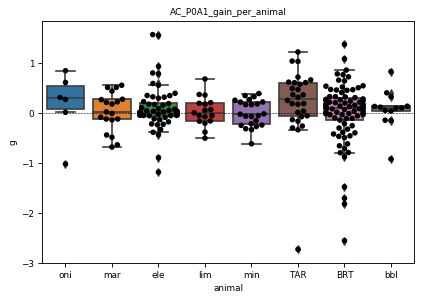

In [89]:
plotme(df[AC & active1], 'animal', 'g', title='AC_P0A1_gain_per_animal')

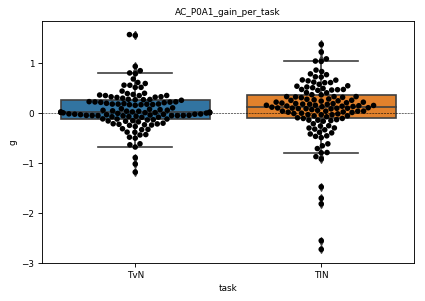

In [90]:
plotme(df[AC & active1], 'task', 'g', title='AC_P0A1_gain_per_task')

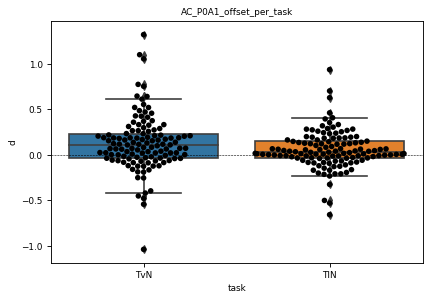

In [103]:
plotme(df[AC & active1], 'task', 'd', title='AC_P0A1_offset_per_task')

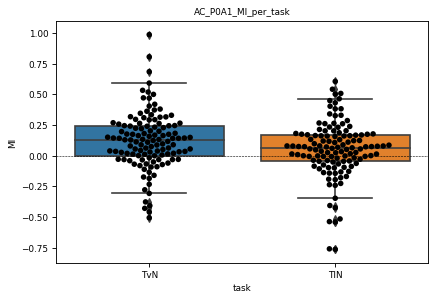

In [91]:
plotme(df[AC & active1], 'task', 'MI', title='AC_P0A1_MI_per_task')

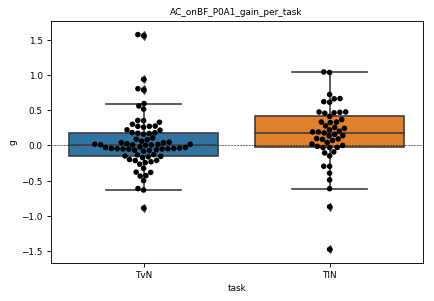

In [92]:
plotme(df[AC & onBF & active1], 'task', 'g', title='AC_onBF_P0A1_gain_per_task')

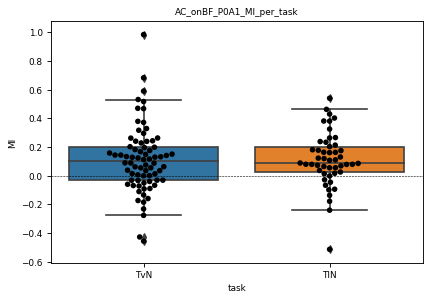

In [104]:
plotme(df[AC & onBF & active1], 'task', 'MI', title='AC_onBF_P0A1_MI_per_task')

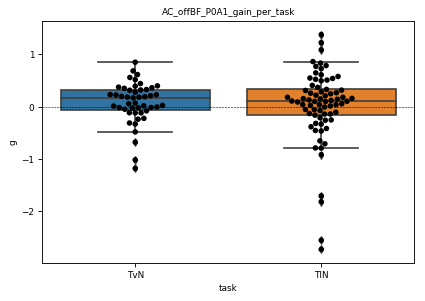

In [94]:
plotme(df[AC & offBF & active1], 'task', 'g', title='AC_offBF_P0A1_gain_per_task')

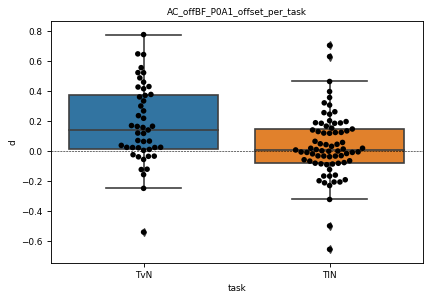

In [105]:
plotme(df[AC & offBF & active1], 'task', 'd', title='AC_offBF_P0A1_offset_per_task')

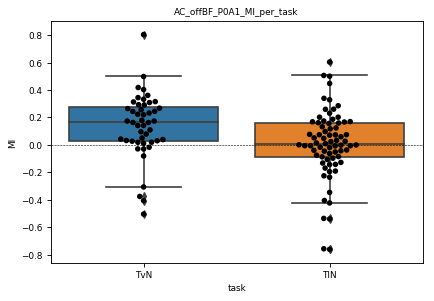

In [95]:
plotme(df[AC & offBF & active1], 'task', 'MI', title='AC_offBF_P0A1_MI_per_task')

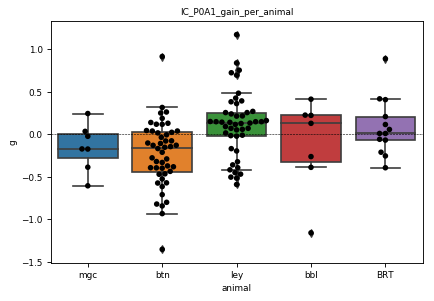

In [96]:
plotme(df[IC & active1], 'animal', 'g', title='IC_P0A1_gain_per_animal')

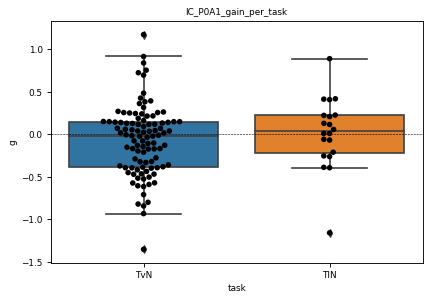

In [106]:
plotme(df[IC & active1], 'task', 'g', title='IC_P0A1_gain_per_task')

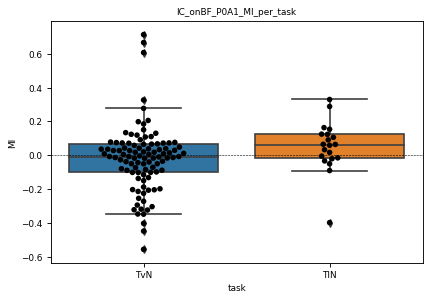

In [98]:
plotme(df[IC & active1], 'task', 'MI', title='IC_onBF_P0A1_MI_per_task')

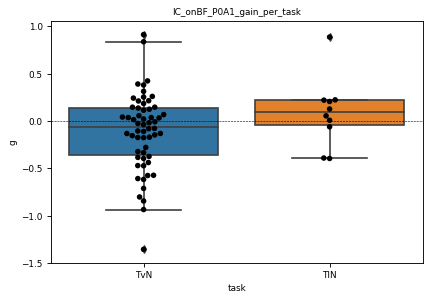

In [99]:
plotme(df[IC & onBF & active1], 'task', 'g', title='IC_onBF_P0A1_gain_per_task')

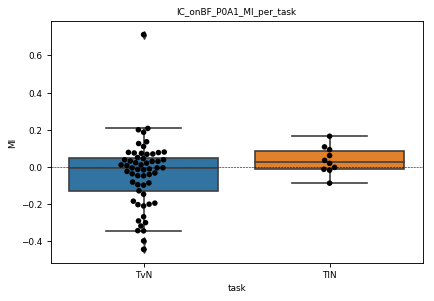

In [100]:
plotme(df[IC & onBF & active1], 'task', 'MI', title='IC_onBF_P0A1_MI_per_task')

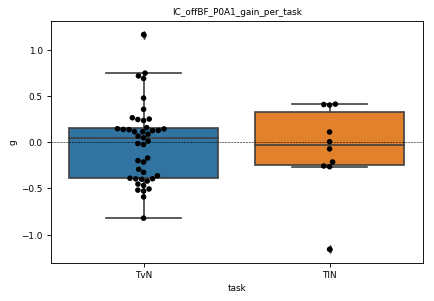

In [101]:
plotme(df[IC & offBF & active1], 'task', 'g', title='IC_offBF_P0A1_gain_per_task')

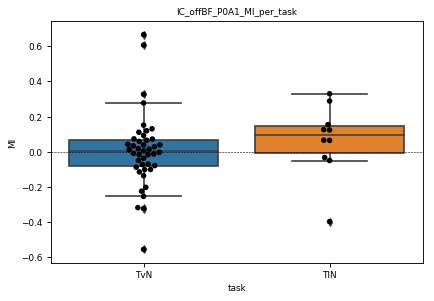

In [102]:
plotme(df[IC & offBF & active1], 'task', 'MI', title='IC_offBF_P0A1_MI_per_task')